In [101]:
pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [72]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy as sp
import statistics
from sklearn import set_config
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             median_absolute_error,
                             max_error, make_scorer
                            )
from sklearn.metrics import PredictionErrorDisplay
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate,cross_val_score,validation_curve,learning_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset,linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Metriques de performances

In [124]:
def get_performances(real_value, estimated_value, metrics):
    perfs = []
    for metric_func in metrics:
        perfs.append((metric_func.__name__, metric_func(real_value, estimated_value)))
    return pd.DataFrame(perfs, columns=["metric", "value"])


def get_all_performances(value_train, values_test, metrics):
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [125]:
METRICS = [r2_score,
           mean_squared_error,
           median_absolute_error,
           max_error
          ]

### Pipeline de modélisation

In [91]:
def model(estimateur,normaliseur):
    model = Pipeline(
        steps=[ ("normaliseur", normaliseur), ("regressor", estimateur)]
    )

    return model

In [19]:
data = gpd.read_file('df_velo.geojson')

In [22]:
data.sample(n=12)

nom_com insee_com  longueur  longueur_pond_hw  \
250  Courcelles-sur-Viosne     95181      1518           1517.00   
577       Moigny-sur-École     91408      7806           7820.00   
134      Brie-Comte-Robert     77053     25817          26696.75   
750                   Réau     77384      5986           6029.75   
896                 Vanves     92075     19619          17693.75   
323                Fromont     77198       134            167.50   
512              Longuesse     95348      1192           1068.75   
534        Mantes-la-Jolie     78361     59657          58529.25   
127   Boutigny-sur-Essonne     91099        18             22.50   
987              Élancourt     78208     53436          54288.75   
254              Courpalay     77135      1799           1799.00   
185                 Chapet     78140     10739          11079.75   

     longueur_pond_adg  difference_hw  difference_adg  cap_com  stat_com  \
250            1734.50          -1.00          216.50      NaN       NaN   
577            7624.75          14.00         -181.25      NaN       NaN   
134           28301.50         879.75         2484.50      NaN       NaN   
750            7053.50          43.75         1067.50      NaN       NaN   
896           15367.75       -1925.25        -4251.25    234.0       7.0   
323             134.00          33.50            0.00      NaN       NaN   
512            1268.00        -123.25           76.00      NaN       NaN   
534           60897.00       -1127.75         1240.00      NaN       NaN   
127              22.50           4.50            4.50      NaN       NaN   
987           63519.25         852.75        10083.25      NaN       NaN   
254            1930.50           0.00          131.50      NaN       NaN   
185           10913.75         340.75          174.75      NaN       NaN   

                               source       surface  population  \
250  IGN:EXPRESS-COG-CARTO-TERRITOIRE  3.625450e+06         288   
577  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.224400e+07        1252   
134  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.994671e+07       18812   
750  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.332199e+07        1919   
896  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.555972e+06       27846   
323  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.066478e+07         247   
512  IGN:EXPRESS-COG-CARTO-TERRITOIRE  8.527732e+06         550   
534  IGN:EXPRESS-COG-CARTO-TERRITOIRE  9.443421e+06       43921   
127  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.624992e+07        2963   
987  IGN:EXPRESS-COG-CARTO-TERRITOIRE  9.245463e+06       25624   
254  IGN:EXPRESS-COG-CARTO-TERRITOIRE  1.474002e+07        1294   
185  IGN:EXPRESS-COG-CARTO-TERRITOIRE  5.202404e+06        1335   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [21]:
data.describe()

,longueur,longueur_pond_hw,longueur_pond_adg,difference_hw,difference_adg,cap_com,stat_com,surface,population
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,82.000000,82.000000,1.005000e+03,1005.000000
mean,14104.276617,13958.353731,14310.651244,-145.922886,206.374627,556.780488,17.951220,8.955252e+06,12040.500498
std,24139.660522,23629.009724,23513.063958,1425.025097,2915.169853,713.441408,21.245713,8.147897e+06,23891.323510
min,2.000000,2.500000,2.500000,-12902.000000,-22854.000000,0.000000,1.000000,9.722876e+04,50.000000
25%,1476.000000,1466.250000,1643.250000,-273.500000,0.000000,120.500000,4.000000,4.481700e+06,850.000000
50%,5293.000000,5337.000000,5725.000000,-8.750000,155.000000,236.000000,8.000000,7.343944e+06,2699.000000
75%,15626.000000,15930.250000,16379.250000,165.500000,870.500000,709.000000,22.750000,1.135592e+07,12266.000000
max,228240.000000,226273.250000,231651.000000,15562.250000,20850.500000,3345.000000,90.000000,1.722864e+08,230981.000000


Les variables nom_com, insee_com, source et geometry ne serons pas utilisées pour la modélisation

In [33]:
base= data[['longueur','longueur_pond_hw','longueur_pond_adg','difference_hw','difference_adg','cap_com','stat_com','surface','population']]

In [ ]:
# from pynsee.download import download_file
# filosofi = download_file("FILOSOFI_COM_2016")

Les station vélib ne sont pas présentes dans toutes les communes équipées d'une piste cyclables, ce qui justifie la préence de valeurs manquantes pour les variables cap_com et stat_com. 2tant en présence de variables numériques positives, ces valeurs manquantes seront imputées par 0. 

In [34]:
base.fillna(0, inplace=True)

/tmp/ipykernel_426/84762160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base.fillna(0, inplace=True)


In [35]:
base.sample(12)

,longueur,longueur_pond_hw,longueur_pond_adg,difference_hw,difference_adg,cap_com,stat_com,surface,population
803,2671,2671.00,2877.50,0.00,206.50,0.0,0.0,5.364064e+06,6110
772,4978,4994.25,5174.75,16.25,196.75,0.0,0.0,5.282652e+06,1850
393,43896,41526.00,43213.75,-2370.00,-682.25,592.0,18.0,6.118281e+06,63748
856,23729,22854.00,26500.75,-875.00,2771.75,0.0,0.0,5.413654e+06,38285
897,6440,6460.25,6444.00,20.25,4.00,0.0,0.0,5.541586e+06,2300
15,48695,44320.25,36619.75,-4374.75,-12075.25,1169.0,36.0,2.543140e+06,58227
5,148909,136007.00,128724.50,-12902.00,-20184.50,3345.0,90.0,8.472060e+06,230981
32,235,235.00,293.75,0.00,58.75,0.0,0.0,3.994067e+06,483
70,12198,12381.25,14324.75,183.25,2126.75,0.0,0.0,3.982144e+06,4600
982,1271,1271.00,1271.00,0.00,0.00,0.0,0.0,1.170370e+07,953


In [36]:
base['log_long']= np.log(base['longueur'])
base['log_lph']=np.log(base['longueur_pond_hw'])
base['log_lpadg']=np.log(base['longueur_pond_adg'])
base['long_surf'] = base['longueur' ]/base['surface']

/tmp/ipykernel_426/358026108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['log_long']= np.log(base['longueur'])
/tmp/ipykernel_426/358026108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['log_lph']=np.log(base['longueur_pond_hw'])
/tmp/ipykernel_426/358026108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

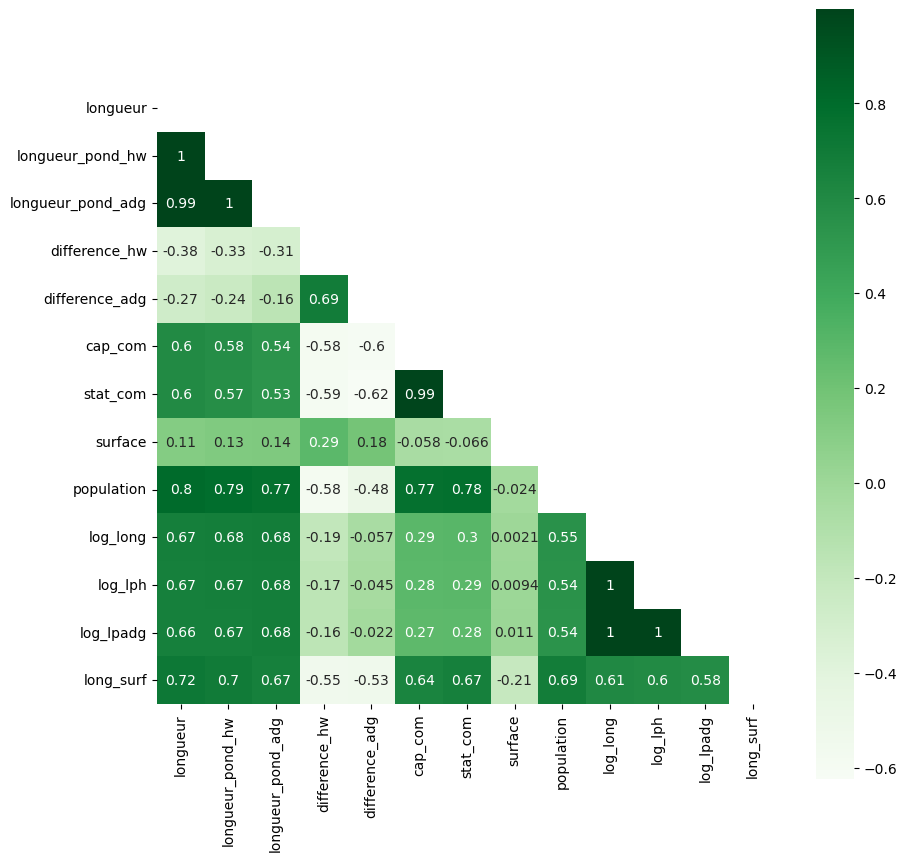

In [37]:
plt.figure(figsize=(10, 10))
corr= base.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(base.corr(), cmap='Greens',square=True, mask=mask, cbar=True, annot=True);

De l'analyse du tableau de corrélation, il ressort que les variables longueur, longueur_pond_hw et longueur_pond_adg sont très fortement correlées entre elles. Elles représentent quasiment la même variable. 
Il en est de même des variables cap_com et stat_com. De ce fait nous ne retiendrns qu'une des variables de chaque relation pour la modélisation

#### Modélisation linéaire

In [106]:
Y= base['longueur']

In [110]:
reg_lin=sm.OLS(Y, sm.add_constant(base[['difference_hw','difference_adg', 'cap_com', 'stat_com', 'surface', 'population','long_surf']])).fit()

In [111]:
print(reg_lin.summary())

                            OLS Regression Results                            
Dep. Variable:               longueur   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     524.4
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:31:16   Log-Likelihood:                -10792.
No. Observations:                1005   AIC:                         2.160e+04
Df Residuals:                     997   BIC:                         2.164e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5306.9523    632.358     -8.

Il ressort des résultats de la regréssion de la lonqueur des aménagements cyclables sur les variables difference_hw,difference_adg,cap_com, stat_com, surface,population et long_surf que le modèle est globalement significatif (Prob (F-statistic)= 0) avec un pouvoit prédictif de plus de 78%. A l'exception de la variable difference_hw, toutes les autres variables, la constante y compris, sont statistiquement significatives.
A l'exception de la variable stat_com, les effets marginaux des des autres variables sont toutes positives. Autrement dit, une augmentation une d'une personne induit une augmentation de 0.65 mètre d'ménagement cyclable.

Bien que ce modèle semble adapté, sa validation nécessite la réalisation d'une série de tests.

#### Vérification des hypothèses de la régréssion linéaire

In [113]:
# Normalité des résidus 
residus= reg_lin.resid
sw_test = shapiro(residus)
print('Test de Shapiro-Wilk pour la normalité des résidus :', sw_test)

Test de Shapiro-Wilk pour la normalité des résidus : ShapiroResult(statistic=0.7270906567573547, pvalue=1.3202448948629724e-37)


Les hypothèses du  test de Shapiro-Wilk utilisé sont :
        - H0 : Les données sont issues d'une distribution normale
        - H1 : Les données ne sont pas issues d'une distribution normale
La valeur de la p_value > 0.05 suggère que les données sont en accords avec l'hypothèse nulle

In [122]:
#Hétéroscédasticité
bp_test = het_breuschpagan(residus, sm.add_constant(base[['difference_hw','difference_adg', 'cap_com', 'stat_com', 'surface', 'population','long_surf']]))
bp_test[1]


3.203958608090139e-57

Les hypothèses du test sont les suivantes :
    - H0 : la variance des erreurs est constante (homoscédasticité). Cela signifie que la variance de l'erreur est la même pour toutes les observations.
    - H1: L'hypothèse alternative suggère que la variance des erreurs n'est pas constante (hétéroscédasticité). Cela signifie que la variance de l'erreur peut varier parmi les observations.
La valeur de la P_value < 0.05 montre que les données sont en accord avec l'hypothèses H1 de présence d'hétéroscédasticité.  

### Modélisation sur les données tronquées

In [41]:
base_t = base[base['cap_com']!=0]

In [44]:
base_t.shape

(81, 13)

In [45]:
base_t.columns

Index(['longueur', 'longueur_pond_hw', 'longueur_pond_adg', 'difference_hw',
       'difference_adg', 'cap_com', 'stat_com', 'surface', 'population',
       'log_long', 'log_lph', 'log_lpadg', 'long_surf'],
      dtype='object')

In [46]:
y= base_t['log_long']

In [47]:
data_t=base_t[['difference_hw','difference_adg', 'cap_com', 'stat_com', 'surface', 'population','long_surf']]

#### Modelisation linéaire

In [77]:
model_lin= model = sm.OLS(y, sm.add_constant(data_t[['difference_hw','difference_adg', 'cap_com', 'stat_com', 'surface', 'population','long_surf']])).fit()

In [78]:
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:               log_long   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     71.89
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           3.48e-30
Time:                        23:37:35   Log-Likelihood:                -6.5737
No. Observations:                  81   AIC:                             29.15
Df Residuals:                      73   BIC:                             48.30
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.0420      0.121     74.

Les résultats de a régréssion du logarithme de la longueur des aménagement cyclables montrent que le modèles est globalement significatif avec un pouvoir explicatif de plus de 86%. Au seuil de 5%, les variables explicatives de la longueur des aménagements sont : la surface de la commune, le ratio longueur/surface et la différence_adg. 
Pour une meilleure interprétation, il est primordial de vérifier les hypothèses du modèle.

In [97]:
model_features=reg_lin.feature_names_in_
df_feature_importance = pd.DataFrame(coef, columns=["coef"], index=model_features)

Text(0.5, 1.0, 'Regression linéaire')

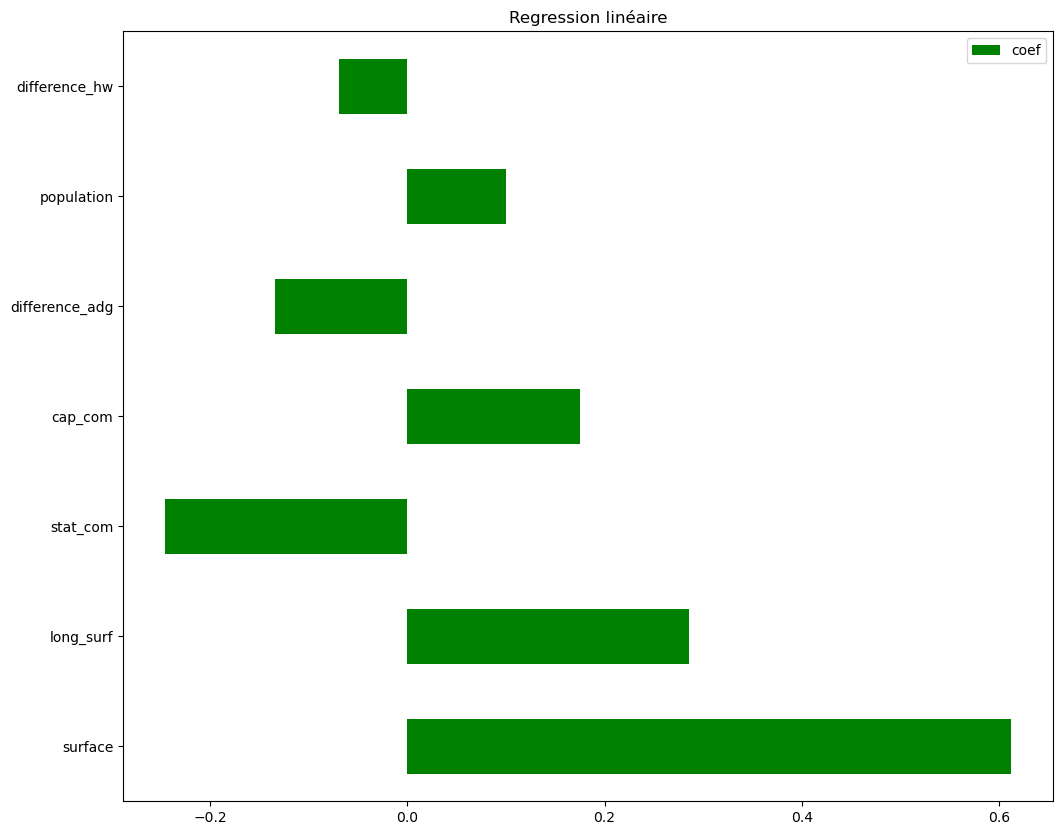

In [99]:
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(40)
 .plot(kind="barh", figsize=(12, 10), color= 'green')
)
plt.title("Regression linéaire")


### Vérification des hypothèses du modèle linéaire

In [86]:
# Évaluation de la validité de la spécification du modèle
reset_test = linear_reset(model_lin)
print('Test de Ramsey RESET pour la validité de la spécification du modèle :', reset_test)

Test de Ramsey RESET pour la validité de la spécification du modèle : <Wald test (chi2): statistic=27.045669048513798, p-value=1.3400086024853162e-06, df_denom=2>


##### Normalité des résidus 

In [79]:
residuals = model.resid

In [80]:
sw_test = shapiro(residuals)
print('Test de Shapiro-Wilk pour la normalité des résidus :', sw_test)

Test de Shapiro-Wilk pour la normalité des résidus : ShapiroResult(statistic=0.9526230096817017, pvalue=0.0045532952062785625)


l'hypothèse de normalité des résidus n'est pas statistiquement vérifiée. Autrement dit, les données ne vérifie pas l'hypothèse selon laquelle les données sont issues d'une distribution normale.

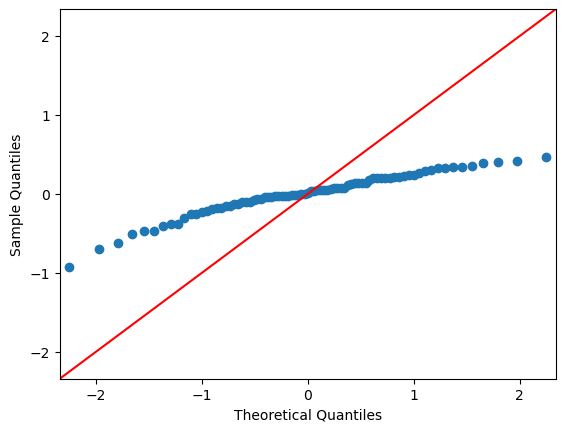

In [85]:
fig = sm.qqplot(residuals , line='45')

#### Prédiction

In [88]:
X_train, X_test, y_train, y_test = train_test_split( data_t, y, test_size=0.30, random_state=42)

In [92]:
reg_lin= model(LinearRegression(),StandardScaler())

In [93]:
reg_lin.fit(X_train, y_train)
y_test_pred = reg_lin.predict(X_test)
y_train_pred = reg_lin.predict(X_train)

In [94]:
print(f"Model score - training data: {reg_lin.score(X_train, y_train)}")
print(f"Model score - test data: {reg_lin.score(X_test, y_test)}")

Model score - training data: 0.9101587377489989
Model score - test data: 0.7327675203231228


In [ ]:
Bien que les estimateurs du modèles ne sont pas consistant, car ne vérifiant le hypothèses du modèle linéaire,
il semble avoir un bon pouvoir prédictif. Ceci peut être dû à la taille des données qui est très petites

In [126]:
get_all_performances(value_train=(y_train, y_train_pred),
                     values_test=(y_test, y_test_pred),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.91,0.73
1,mean_squared_error,0.05,0.13
2,median_absolute_error,0.15,0.21
3,max_error,0.64,1.16


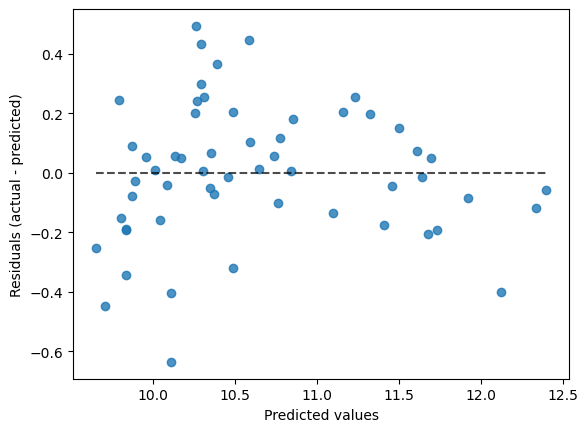

In [123]:
display = PredictionErrorDisplay(y_true=y_train, y_pred=y_train_pred)
display.plot()
plt.show()